In [4]:
# 필요한 패키지 import

import os # 환경 변수나 디렉토리, 파일 등 OS자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리
import matplotlib.pyplot as plt # 시각화
import numpy as np
import dlib # 이미지 처리 및 기계 학습, 얼굴인식을 할 수 있는 라이브러리

### 얼굴이 포함된 사진을 준비

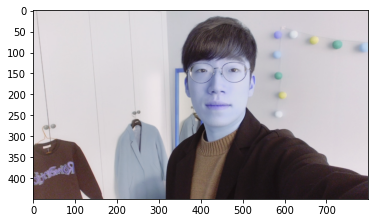

In [24]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관
plt.imshow(img_bgr) 
plt.show()

matplotlib, dlib 등은 RGB순으로 사용하지만, opencv는 예외적으로 BGR순으로 사용한다.

붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력되므로

opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용해 출력하려면 색깔보정이 필요.

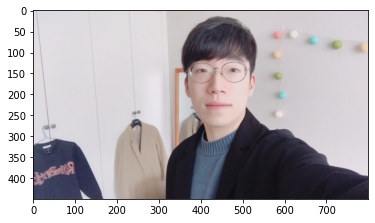

In [25]:
# 색깔보정(BGR to RGB)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### face detector( of dlib) - Histogram of Oriented Gradients와 Support Vector Machine을 사용해서 얼굴을 찾아낸다.

HOG - 색상의 변화량 측정

SVM - 얼굴인지 아닌지, 선형 분류

In [26]:
# 기본 얼굴 감지기를 반환, detector를 선언

detector_hog = dlib.get_frontal_face_detector()

In [27]:
# detector_hog를 이용해 얼굴의 bounding box를 추출

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

detector_hog의 두 번째 파라미터는 이미지 피라미드의 수.

이미지 피라미드_upsampling방법으로 이미지 크기를 키우는 것

upsampling_데이터의 크기를 키우는 것

rectangles[[(345, 98) (531, 284)]]


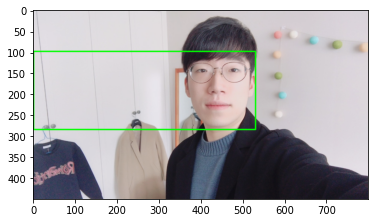

In [28]:
# 찾은 얼굴을 화면에 출력

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (1,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점, 종료점의 좌표로 직각 사각형 표현
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Face Landmark Localization - bounding box로 잘라낸 얼굴 이미지를  이용해서 이목구비위 위치를 알아냄

bounding box를 찾고, box 내부의 keypoint를 예측하는 방식으로 진행

In [8]:
# dlib의 pretrained model을 사용

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
# landmark 모델의 주소를 model_path 변수에 저장

landmark_predictor = dlib.shape_predictor(model_path)
# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
# landmark_predictor는 RGB이미지와 dlib.rectangle을 입력받고 dlib.full_object_detection을 반환
# dlib.rectangle : 내부를 예측하는 박스
# dlib.full_object_detection : 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [9]:
list_landmarks = []
# 랜드마크의 위치를 저장할 list 생성

# 얼굴 영역 박스마다 face landmark를 찾아냅니다.
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # 각 landmark 위치정보를 (x, y)형태로 변환하여 list_points 리스트로 저정
    list_landmarks.append(list_points)
    # list_landmarks에 랜드마크 리스트를 저정
    
print(len(list_landmarks[0]))
# 얼굴이 n개인 경우 list_landmarks는 n개의 원소
# 각 원소는 68개의 랜드마크 위치가 나열된 list
# list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


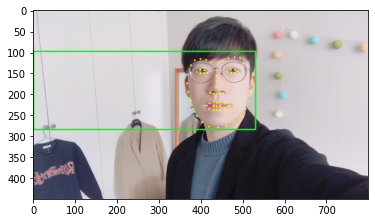

In [10]:
# list_landmarks의 원소가 1개이므로 아래 반복문이 1번만 실행
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        # cv2.circle: OpenCV의 원을 그리는 함수
        # img_show 이미지 위 각각의 point에
        # 크기가 2, (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
        # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# RGB이미지로 전환
plt.imshow(img_show_rgb) # 이미지를 준비
plt.show()

### 스티커 적용하기

왕관 스티커의 위치, 크기에 대한 계산이 필요

In [11]:
# 좌표의 확인
# zip() : 두 그룹의 데이터를 서로 엮어어주는 파이썬의 내장 함수
# dlib_rects와 landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 -> (437, 182-(186+1//2))
    w = h = dlib_rect.width() #얼굴영역의 가로를 차지하는 픽셀의 수
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


In [12]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png' # 왕관이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지 호출
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조종
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(187, 187, 3)


In [13]:
# x,y,w,h 모두 반복문 안에서 지정해준 값
# x = 코 부위의 x값 = 437
# y = 코 부위의 y 값 = 89
# w = 얼굴 영역의 가로를 차지하는 픽셀의 수 = 187
# h = 얼굴 영역의 가로를 차지하는 픽셀의 수 = 187
refined_x = x - w // 2 # 437 - (187 // 2) = 437-93 = 344
refined_y = y - h # 89-187 = -98
# 원본 이미지에 스티커 이미지를 추가하기 위해 x, y좌표를 조정. 이미지 시작점이 top-left좌표이기 때문
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 - 이미지 범위를 벗어남
# 이마위치 - 왕관높이 가 이미지 범위를 초과하기 때문에 음수로 산출
# openCV는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하기 때문에 스티커 이미지를 잘라줘야.

(x,y) : (344,-98)


In [14]:
# 왕관이미지가 이미지 밖에서 시작하지 않도록 조정이 필요
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop하고, top의 x좌표와 y좌표를 각각의 경우에 맞춰 원본 이미지의 경계값으로 수정
# 음수값만큼 왕관이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관이미지를 씌우기 위해 왕관이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이기 때문에, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 된다(187개 중에서 98개가 잘려나감)
    refined_y = 0
    
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (344,0)


In [15]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[0:0+89, 344:344+187]
# img_show[0:89, 344:531]
# 즉, x좌표는 344~531 / y좌표는 0~89가 됨
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


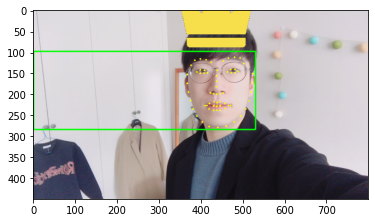

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

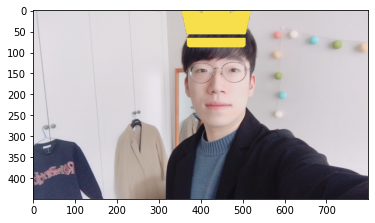

In [17]:
# 위에서 설명했으므로 생략
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

# PROJECT

In [2]:
# 패키지 Import

import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


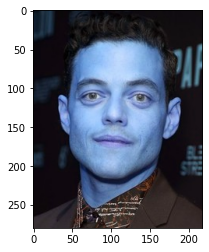

In [41]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ramimalek.jpg'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관
plt.imshow(img_bgr) 
plt.show()

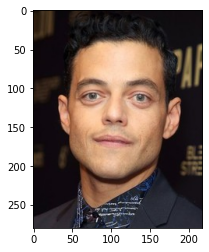

In [42]:
# 색깔보정(BGR to RGB)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [43]:
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

print(dlib_rects)



rectangles[[(38, 67) (167, 196)]]


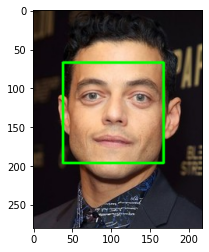

In [44]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점, 종료점의 좌표로 직각 사각형 표현
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [45]:
# dlib의 pretrained model을 사용

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

In [46]:
list_landmarks = []
# 랜드마크의 위치를 저장할 list 생성

# 얼굴 영역 박스마다 face landmark를 찾아내고
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # 각 landmark 위치정보를 (x, y)형태로 변환하여 list_points 리스트로 저정
    list_landmarks.append(list_points)
    # list_landmarks에 랜드마크 리스트를 저정
    
print(len(list_landmarks[0]))

68


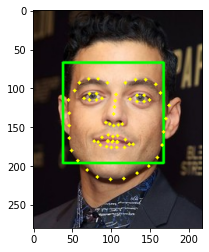

In [47]:
# list_landmarks의 원소가 1개이므로 아래 반복문이 1번만 실행
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        # cv2.circle: OpenCV의 원을 그리는 함수
        # img_show 이미지 위 각각의 point에
        # 크기가 2, (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
        # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# RGB이미지로 전환
plt.imshow(img_show_rgb) # 이미지를 준비
plt.show()

In [48]:
# 왕관이미지를 씌우기 위한 계산

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 -> (437, 182-(186+1//2))
    w = h = dlib_rect.width() #얼굴영역의 가로를 차지하는 픽셀의 수
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(103, 133)
(x,y) : (103,68)
(w,h) : (130,130)


In [49]:
# 왕관이미지의 경로

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지 호출
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조종
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(130, 130, 3)


In [50]:
refined_x = x - w // 2 # 437 - (187 // 2) = 437-93 = 344
refined_y = y - h # 89-187 = -98
# 원본 이미지에 스티커 이미지를 추가하기 위해 x, y좌표를 조정. 이미지 시작점이 top-left좌표이기 때문
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 - 이미지 범위를 벗어남

(x,y) : (38,-62)


In [51]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관이미지를 씌우기 위해 왕관이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이기 때문에, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 된다(187개 중에서 98개가 잘려나감)
    refined_y = 0
    
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (38,0)


In [52]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
 
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

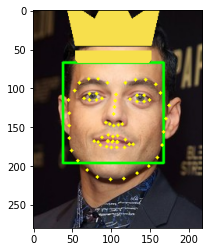

In [53]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

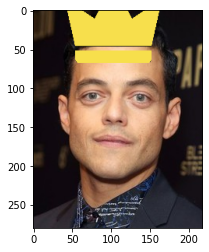

In [54]:
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 수염 스티커

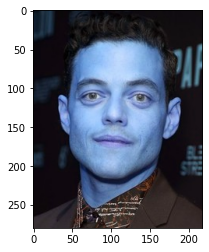

In [88]:
# 준비 이미지 확인

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/ramimalek.jpg'
img_bgr = cv2.imread(my_image_path) #openCV로 준비된 이미지 호출
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관
plt.imshow(img_bgr) 
plt.show()

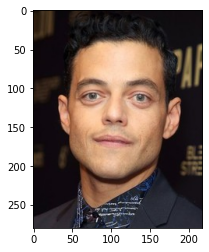

In [89]:
# 색깔보정(BGR to RGB)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(38, 67) (167, 196)]]


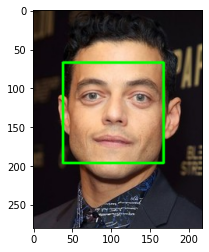

In [90]:
# 얼굴 영역 확인

detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 색깔보정, 이미 진행했음.
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점, 종료점의 좌표로 직각 사각형 표현
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [91]:
# dlib의 pretrained model을 사용

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

In [92]:
list_landmarks = []
# 랜드마크의 위치를 저장할 list 생성

# 얼굴 영역 박스마다 face landmark를 찾아내고
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # 각 landmark 위치정보를 (x, y)형태로 변환하여 list_points 리스트로 저정
    list_landmarks.append(list_points)
    # list_landmarks에 랜드마크 리스트를 저정
    
print(len(list_landmarks[0]))

68


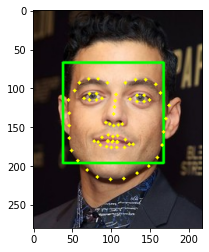

In [93]:
# list_landmarks의 원소가 1개이므로 아래 반복문이 1번만 실행
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        # cv2.circle: OpenCV의 원을 그리는 함수
        # img_show 이미지 위 각각의 point에
        # 크기가 2, (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
        # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# RGB이미지로 전환
plt.imshow(img_show_rgb) # 이미지를 준비
plt.show()

In [134]:
# 수염이미지를 붙이기 위한 계산 30 -> 8

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[8]) # 코의 index
    x = landmark[8][0] # 이미지에서 코 부위의 x값
    y = landmark[8][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 -> (437, 182-(186+1//2))
    w = h = dlib_rect.width() #얼굴영역의 가로를 차지하는 픽셀의 수
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(99, 217)
(x,y) : (99,152)
(w,h) : (130,130)


In [135]:
# 수염이미지의 경로

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/moustache02.png'
img_sticker = cv2.imread(sticker_path, 1) # 스티커 이미지 호출
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조종
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(130, 130, 3)


In [136]:
refined_x = x - w // 2 # 437 - (187 // 2) = 437-93 = 344
refined_y = y - h # 89-187 = -98
# 원본 이미지에 스티커 이미지를 추가하기 위해 x, y좌표를 조정. 이미지 시작점이 top-left좌표이기 때문
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 - 이미지 범위를 벗어남

(x,y) : (34,22)


In [137]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관이미지를 씌우기 위해 왕관이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이기 때문에, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 된다(187개 중에서 98개가 잘려나감)
    refined_y = 0
    
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (34,22)


In [138]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
 
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

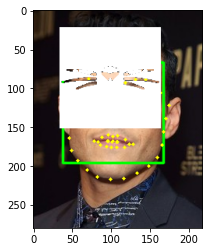

In [139]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

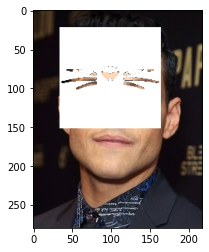

In [140]:
# 수염 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

### 바운딩박스가 얼굴 부분을 포함해서 이미지 왼쪽 시작부분부터 나타났는데, 원인을 찾지 못했음. 반복실행을 통해 문제가 수정되었음.

### 수염스티커의 배경이 나타나는 이유를 수정하고 싶었으나 해당부분이 브로드캐스팅 문제를 발생시키고 있음.

### 사진 위에 고양이수염을 붙이고 싶지만 생각처럼 되지 않는다. 이유가 뭘까?

### Landmark의 선정? 어쨌든 얼굴 수직 중앙에 해당하는 지점이 후보가 될 것으로 추정되기 때문에, 대상을 찾는 것은 시행착오로 가능할 것으로 생각된다. 하지만 중앙이 아니라면?

### 얼굴아래쪽으로 훨씬 내려와야 할 것 같은데, 가장 아래 쪽에 위치한 landmark8으로 수정을 했음에도 얼굴 아래쪽으로 더 내려와야 할 것 같다. 랜드마크를 선정하는 문제가 아니라, 별도의 계산이 필요하다는 의미일까?

### 배경이 흰색으로 존재하는 이유는 무엇일까? 수염의 외곽선은 분명히 보이고, 파일도 특별히 문제가 있다고 판단이 되지는 않는다. 다른 파일로 시도해보면 좋겠다.